# Estimating Brunt-Vaisala frequency

In [32]:
import numpy as np
from MITgcmutils import rdmds, densjmd95
from hspython import loadgrid
import matplotlib.pyplot as plt

In [33]:
# Constants
rhoconst = 1.035e3;
g = 9.81;
fg_color = 'white'
bg_color = 'black'
scale = 1e5;

In [34]:
grd = loadgrid('so_box', varname=['XC','YC','RC','hFacC','DRC','RF'])
[lz,ly,lx] = grd.hFacC.shape;

- Compute the stratification frequency using DRHODR. It is defined at the center.

In [35]:
dRHOdr = rdmds('ocestrat', 9, rec=0);    # DRHODR is in the first record
Nsq = - dRHOdr * g / rhoconst * scale;

- Using T and S. When estimating density, use the same pressure between two levels.
It is defined at the interface, so slightly different from Nsq

In [37]:
T = rdmds('dynDiag', 9, rec=2);    # THETA is in the third record
S = rdmds('dynDiag', 9, rec=3);    # SALT is in the fourth record
Nsq_TS = np.zeros([lz,ly,lx]);
for k in range(1,lz):
    press = -rhoconst * g * grd.RF[k] / 1e4;      # pressure at the interface
    urho = densjmd95(S[k-1,...],T[k-1,...],press);       # rho at the center of the upper level with the pressure at the interface
    lrho = densjmd95(S[k,...],T[k,...],press);   # rho at the center of the lower level with the pressure at the interface
    drhodr = (urho - lrho) / grd.DRC[k] * grd.mskC[k,...] * grd.mskC[k-1,...]
    Nsq_TS[k,...] = -drhodr * g / rhoconst * scale

- Estimating N$^2$ using RHOAnoma is not easy because RHOAnoma is computed using the pressure at that level 

In [39]:
rho = rdmds('ocestrat', 9, rec=1) + rhoconst;    # RHOAnoma is in the second record
Nsq_ra = np.zeros([lz,ly,lx]);
for k in range(1,lz):
    drhodz = (rho[k-1,:,:] - rho[k,:,:]) / grd.DRC[k] * grd.mskC[k,...] * grd.mskC[k-1,...]
    Nsq_ra[k,:,:] = -drhodz * g / rhoconst * scale;

+ Compare N$^2$

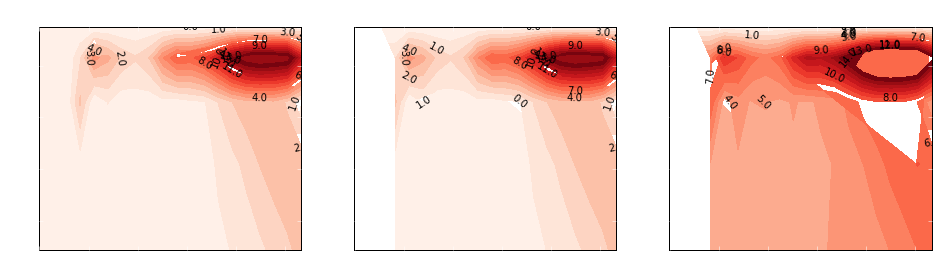

In [43]:
%matplotlib inline
showz=5;
showx=5;
[X,Y] = np.meshgrid(grd.YC[:,0],grd.RC[:showz]);

f, ax = plt.subplots(1,3, figsize=(16,4));

im = ax[0].contourf(X, Y, Nsq[:showz,:,showx], np.arange(0,15.1,1), cmap='Reds')
cb = plt.clabel(im,colors='black',fmt='%3.1f')
im.ax.axes.tick_params(color=fg_color, labelcolor=fg_color)
ax[0].set_title('N$^2$, from DRHODR [x 10$^5$ s$^{-1}$]', color=fg_color, fontsize=15)

im = ax[1].contourf(X, Y, Nsq_TS[:showz,:,showx], np.arange(0,15.1,1), cmap='Reds')
cb = plt.clabel(im,colors='black',fmt='%3.1f')
im.ax.axes.tick_params(color=fg_color, labelcolor=fg_color)
ax[1].set_title('N$^2$, from T/S [x 10$^5$ s$^{-1}$]', color=fg_color, fontsize=15)

im = ax[2].contourf(X, Y, Nsq_ra[:showz,:,showx], np.arange(0,15.1,1), cmap='Reds')
cb = plt.clabel(im,colors='black',fmt='%3.1f')
im.ax.axes.tick_params(color=fg_color, labelcolor=fg_color)
ax[2].set_title('N$^2$, from RHOAnoma [x 10$^5$ s$^{-1}$]', color=fg_color, fontsize=15)